# Imports

In [21]:
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path

Path("report/figures").mkdir(parents=True, exist_ok=True)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)

# Scikit-learn: preprocessing & pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Scikit-learn: models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit-learn: metrics & utilities
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    classification_report
)
from sklearn.base import clone
from sklearn.inspection import permutation_importance   

# Data Exploration

In [22]:
df_raw = pd.read_csv("data/titanic_augmented.csv")

print(df_raw.info())
print("\ncabin number NaNs: ", df_raw.Cabin.isna().sum())
print("\nage number NaNs: ", df_raw.Age.isna().sum())
print("\ncabin room number number NaNs: ", df_raw.cabin_room_number.isna().sum())
print("\nembarked number NaNs: ", df_raw.Embarked.isna().sum())
print("\nSurvived count: ", df_raw.Survived.sum())
print("\nDeath count: ", df_raw.__len__() - df_raw.Survived.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

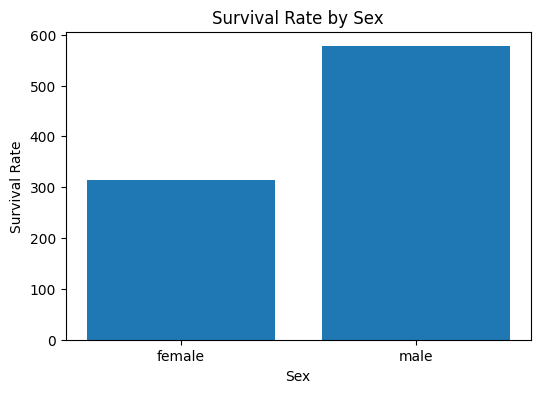

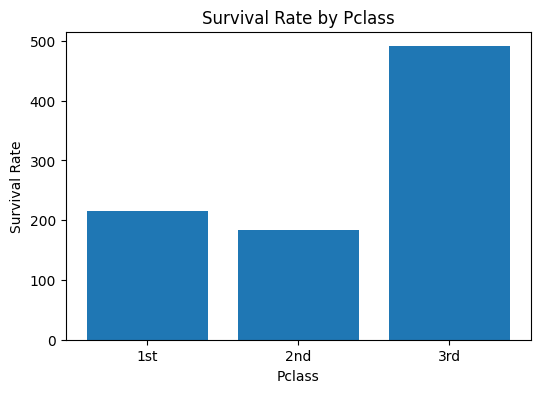

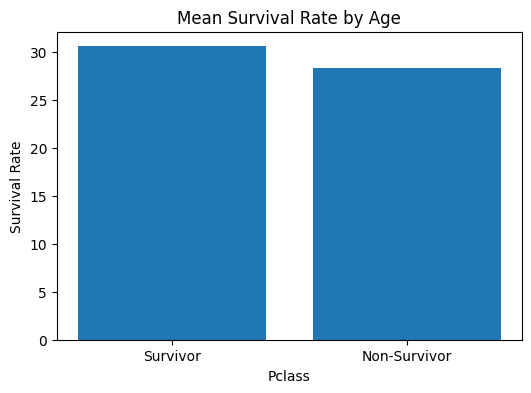

In [23]:
df_survivor_by_sex = df_raw.groupby("Sex").Survived.count()
df_survived_by_pclass = df_raw.groupby("Pclass").Survived.count()
df_age_by_survived = df_raw.groupby("Survived").Age.mean()

plt.figure(figsize=(6, 4))
plt.bar(df_survivor_by_sex.index, df_survivor_by_sex.values)

plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Sex")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(df_survived_by_pclass.index, df_survived_by_pclass.values)
plt.xlabel("Pclass")
plt.xticks([1, 2, 3], ["1st", "2nd", "3rd"])
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Pclass")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(df_age_by_survived.index, df_age_by_survived.values)
plt.xlabel("Pclass")
plt.xticks([0, 1], ["Survivor", "Non-Survivor"])
plt.ylabel("Survival Rate")
plt.title("Mean Survival Rate by Age")
plt.show()

# Data Wrangling

In [24]:
drop_cols = [
    
    # Identifier columns:
    #     - PassengerId, Name, Ticket, booking_reference, service_id

    # Redundant Variables:
    #     - SibSp + Parch + is_alone -> can be condensed to family_size
    #     - fare_per_person & age_fare_ratio -> ratios of column data
    #     - Cabin & cabin_room_number -> sparse, tons of missing data here
    #     - name_length & name_word_count -> longer names could indicate higher status,
    #                                         but there are stronger indicators (Pclass is one of them)
    

    "PassengerId", "Name", "Ticket", "Cabin", "booking_reference", "service_id", "title",
    "SibSp", "Parch", "is_alone", "fare_per_person", "age_fare_ratio", "cabin_room_number",
    "name_length", "name_word_count"
]
df = df_raw.drop(columns=[c for c in drop_cols if c in df_raw.columns]).copy()

X = df.drop(columns=["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)




age median:  29.0

age median group by pclass:  Pclass
1    38.0
2    29.5
3    24.0
Name: Age, dtype: float64


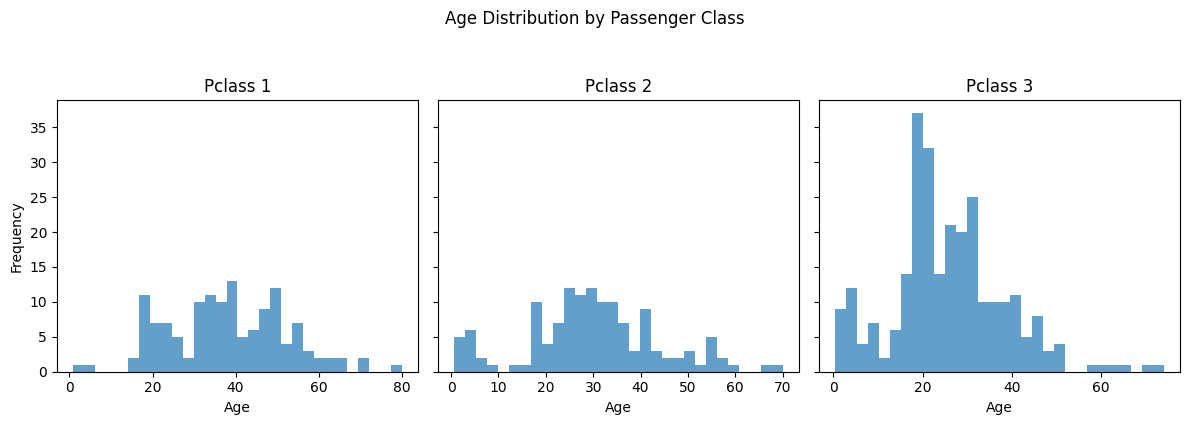


embarked mode 0    S
Name: Embarked, dtype: object


In [25]:
print("\nage median: ", X_train.Age.median())
print("\nage median group by pclass: ", X_train.groupby("Pclass").Age.median())
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, pclass in enumerate(sorted(X_train["Pclass"].unique())):
    axes[i].hist(X_train[X_train["Pclass"] == pclass]["Age"], bins=30, alpha=0.7)
    axes[i].set_title(f"Pclass {pclass}")
    axes[i].set_xlabel("Age")
    if i == 0:
        axes[i].set_ylabel("Frequency")

fig.suptitle("Age Distribution by Passenger Class", y=1.05)
plt.tight_layout()
plt.show()


print("\nembarked mode", X_train.Embarked.mode())

In [26]:
# Impute missing values using TRAIN statistics only
age_medians = X_train.groupby("Pclass").Age.median()
embarked_mode = X_train.Embarked.mode()


X_train.loc[:, "Age"] = X_train["Age"].fillna(X_train["Pclass"].map(age_medians))
X_test.loc[:, "Age"]  = X_test["Age"].fillna(X_test["Pclass"].map(age_medians))

X_train.loc[:, "Embarked"] = X_train["Embarked"].fillna(embarked_mode)
X_test.loc[:, "Embarked"]  = X_test["Embarked"].fillna(embarked_mode)

# One-hot encode categorical columns that exist
cat_cols = [c for c in ["Sex", "Embarked", "title_group", "cabin_deck"] if c in X_train.columns]
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# Align columns so train/test match
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (668, 21) Test shape: (223, 21)


# Functions for Evaluation and Plotting

In [27]:

# StratifiedKFold was used since there are many more non-survivors than survivors
# Stratified sampling improves sample accuracy and precision by ensuring representation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

def evaluate(name, model, X_train, y_train, X_test, y_test, cv):
    '''
    Evaulates different models and stores the statistics in a dictonary
    '''
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "name": name,
        "model": model,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "test_acc": accuracy_score(y_test, y_pred),
        "test_mse": mean_squared_error(y_test, y_pred),
        "cm": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred
    }

def feature_importance(name, fitted_model, X_train, X_test, y_train, y_test):
    """
    Returns a dataframe of the features with their importance

    fitted_model: the model used in `model.fit(X_train, y_train)`
    name: name of the model used (LDA, KNN, etc)
    """

    if name in ["LDA", "Logistic Regression"]:
        coefs = fitted_model.named_steps["model"].coef_.ravel()
        return pd.DataFrame({
            "feature": X_train.columns,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        }).sort_values("abs_coef", ascending=False)
    
    elif name == "KNN":
        result = permutation_importance(
            fitted_model,
            X_test,
            y_test,
            n_repeats=10,
            random_state=42,
            scoring="accuracy")
        importances = result.importances_mean
        return pd.DataFrame({
            "feature": X_train.columns,
            "abs_coef": np.abs(importances)
        }).sort_values("abs_coef", ascending=False)
    
    elif name == "Decision Tree":
        importances = fitted_model.named_steps["model"].feature_importances_
        return pd.DataFrame({
            "feature": X_train.columns,
            "importances": importances
        }).sort_values("importances", ascending=False)

def plot_feature_importance(
    df,
    ax,
    model_name="",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=15,
    title="Feature Importance",
    title_suffix=""
):
    df_plot = (
        df.sort_values(importance_col, ascending=True)
          .tail(top_n)
    )

    ax.barh(df_plot[feature_col], df_plot[importance_col])
    ax.set_xlabel("Importance")
    ax.tick_params(axis="y", labelsize=15)
    ax.set_title(f"{model_name} ({title_suffix})")
    
def plot_accuracy_bar(results, title_suffix=""):
    perf = pd.Series({r["name"]: r["test_acc"] for r in results}).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=perf.index, y=perf.values)
    for i, v in enumerate(perf.values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontweight="bold")
    plt.ylim(max(0, perf.min() - 0.1), min(1.0, perf.max() + 0.1))
    plt.title(f"Performance Comparison (Accuracy) on Test Set ({title_suffix})")
    plt.ylabel("Accuracy Score")
    plt.xlabel("Classification Models")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, title_suffix=""):
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for ax, r in zip(axes, results):
        sns.heatmap(r["cm"], annot=True, fmt="d", cmap="Blues", ax=ax,
                    xticklabels=["Died", "Survived"], yticklabels=["Died", "Survived"])
        ax.set_title(f"Confusion Matrix: {r['name']} ({title_suffix})")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Fitting Pipeline


In [28]:
pipelines = {

    # `Pipeline` allows you to sequentially apply a list of transformers to preprocess the data
    # found here: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

    # Basically, the Pipeline will apply the `StandardScalar` on the train/test data, and then will
    # be used to fit the model (LDA, LR, etc) for evaluation. 
    # Data leakage can occur during cross-validation when doing y_pred.
    
    # Pipeline also helps avoid data leakage from the test data into the trained model during cross-validation 
    # found here: https://scikit-learn.org/stable/modules/compose.html#pipeline


    "LDA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearDiscriminantAnalysis())
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier())
    ])
}

# Running Baseline models

In [29]:
baseline_results = []
feature_rank_baseline = []
baseline_models = {}

results_table_bl = []


for name, model in pipelines.items():
    r = evaluate(name, model, X_train, y_train, X_test, y_test, cv=cv)
    baseline_results.append(r)
    results_table_bl.append({
        "Model_baseline": name,
        "CV Accuracy (Mean)": r["cv_mean"],
        "CV Accuracy (Std)": r["cv_std"],
        "Test Accuracy": r["test_acc"],
        "Test MSE": r["test_mse"]
    })

    # fit on full training data so we can extract importances
    fitted = model.fit(X_train, y_train)
    baseline_models[name] = fitted
    feature_rank_baseline.append({name: feature_importance(name, fitted, X_train, X_test, y_train, y_test)})
    
    # print(f"\n=== {name} (Baseline) ===")
    # print(f"CV Accuracy: mean={r['cv_mean']:.4f}, std={r['cv_std']:.4f}")
    # print(f"Test Accuracy: {r['test_acc']:.4f}")
    # print(f"Test MSE:      {r['test_mse']:.4f}")
    # print(classification_report(y_test, r['y_pred']))

lda_baseline_df = feature_rank_baseline[0]["LDA"]
lr_baseline_df = feature_rank_baseline[1]['Logistic Regression']
knn_baseline_df = feature_rank_baseline[2]['KNN']

results_table_bl_df = pd.DataFrame(results_table_bl)
results_table_bl_df

,Model_baseline,CV Accuracy (Mean),CV Accuracy (Std),Test Accuracy,Test MSE
0,LDA,0.824868,0.043938,0.838565,0.161435
1,Logistic Regression,0.836808,0.045223,0.825112,0.174888
2,KNN,0.813923,0.048263,0.802691,0.197309


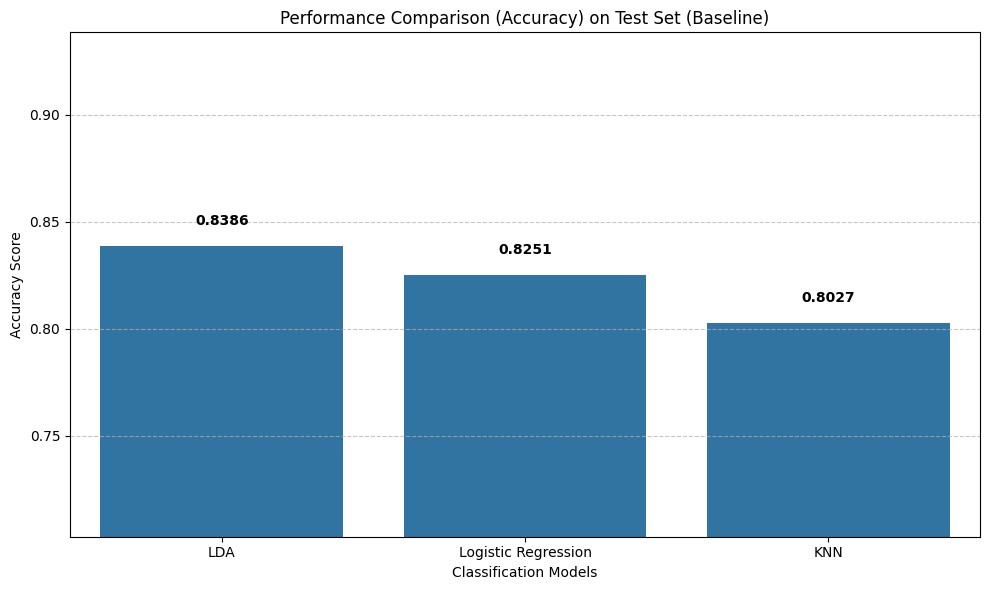

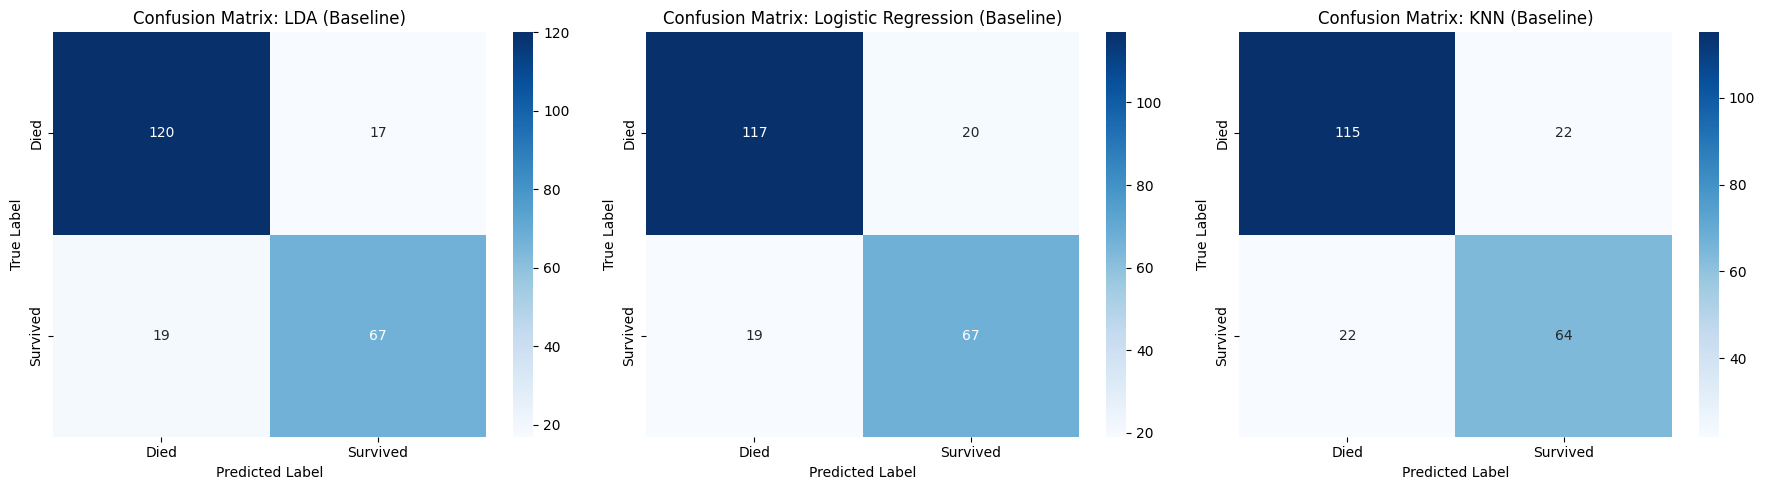

In [30]:
plot_accuracy_bar(baseline_results, title_suffix="Baseline")
plot_confusion_matrices(baseline_results, title_suffix="Baseline")

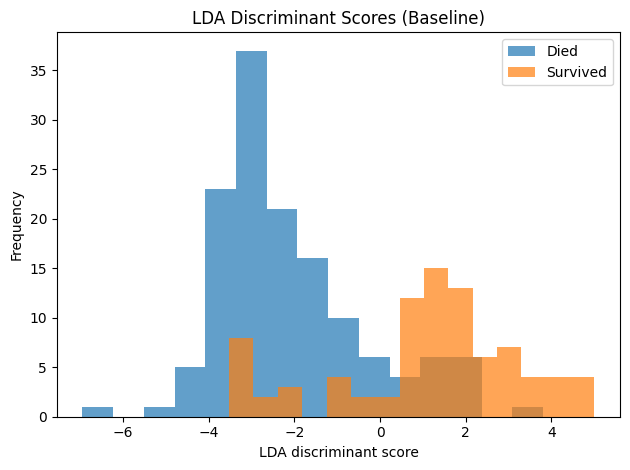

In [31]:
lda_baseline_model = baseline_models["LDA"]
lda_scores_baseline = lda_baseline_model.decision_function(X_test)
plt.figure()
plt.hist(lda_scores_baseline[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_baseline[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Discriminant Scores (Baseline)")
plt.legend()
plt.tight_layout()
plt.show()

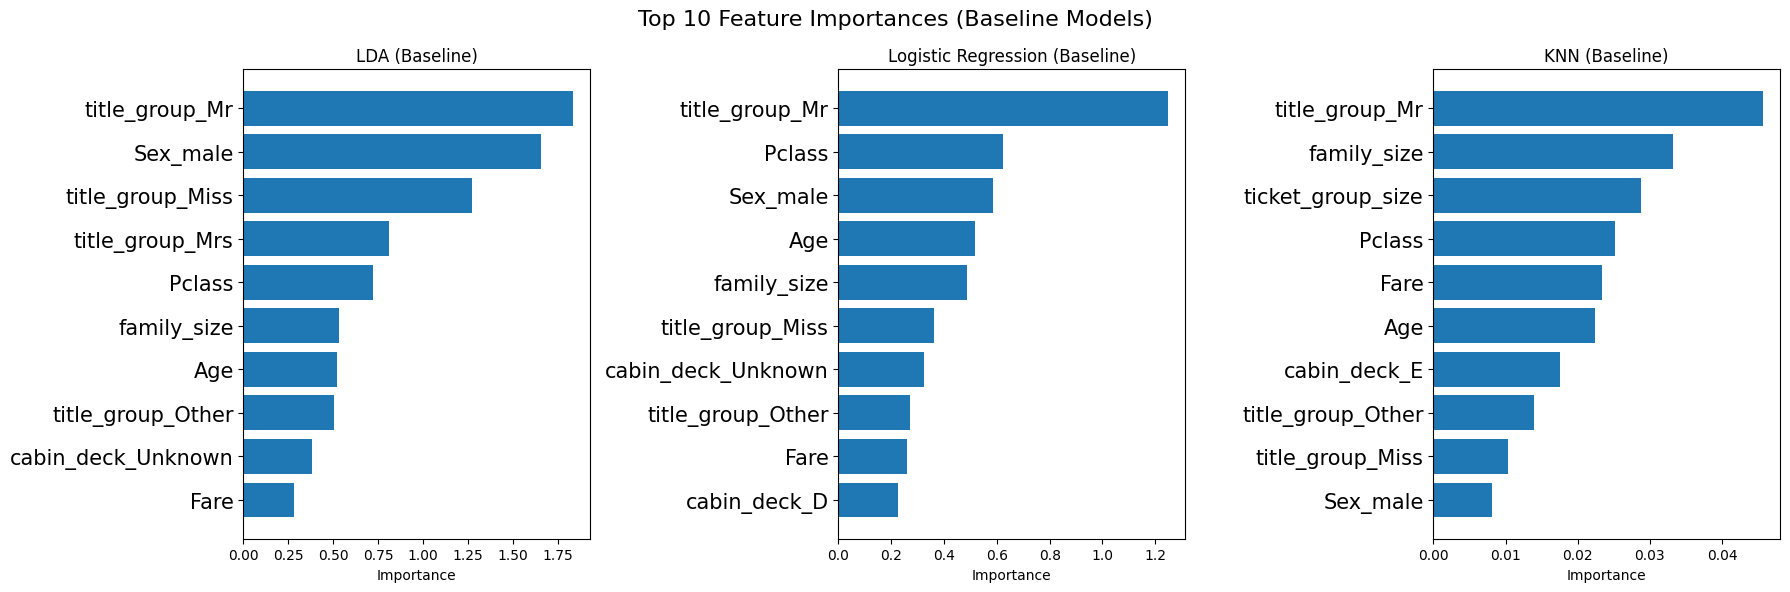

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

plot_feature_importance(
    lda_baseline_df,
    ax=axes[0],
    model_name="LDA",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    lr_baseline_df,
    ax=axes[1],
    model_name="Logistic Regression",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    knn_baseline_df,
    ax=axes[2],
    model_name="KNN",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

fig.suptitle("Top 10 Feature Importances (Baseline Models)", fontsize=16)
plt.tight_layout()
plt.show()

# Hyparameter Tuning and Running Tuned Models

In [33]:
param_grids = {

    
   # Pipeline can be combined with GridSearchCV as mentioned in the Pipeline documentation.
   # GridSearchCV is an exhaustive search overspecified parameter values for an estimator (the models in the Pipeline).

    "LDA": [
        {"model__solver": ["svd"]},
        {"model__solver": ["lsqr"], "model__shrinkage": ["auto"] + list(np.linspace(0, 1, 21))}
    ],
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"],
        "model__solver": ["liblinear"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11, 15],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    }
}

best_models = {}
for name, pipe in pipelines.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=cv,
        scoring="accuracy",
        n_jobs=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"\n{name} best params: {grid.best_params_}")
    print(f"{name} best CV score: {grid.best_score_:.4f}")


LDA best params: {'model__shrinkage': 0.05, 'model__solver': 'lsqr'}
LDA best CV score: 0.8269

Logistic Regression best params: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Logistic Regression best CV score: 0.8408

KNN best params: {'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
KNN best CV score: 0.8249


In [34]:
tuned_results = []
feature_rank_tuned = []
results_table_tuned = []


for name, model in best_models.items():
    r = evaluate(name, model, X_train, y_train, X_test, y_test, cv=cv)
    tuned_results.append(r)
    results_table_tuned.append({
        "Model_tuned": name,
        "CV Accuracy (Mean)": r["cv_mean"],
        "CV Accuracy (Std)": r["cv_std"],
        "Test Accuracy": r["test_acc"],
        "Test MSE": r["test_mse"]
    })
    fitted = model.fit(X_train, y_train)

    feature_rank_tuned.append({
        name: feature_importance(name, fitted, X_train, X_test, y_train, y_test)
    })

    # print(f"\n=== {name} (tuned) ===")
    # print(f"CV Accuracy: mean={r['cv_mean']:.4f}, std={r['cv_std']:.4f}")
    # print(f"Test Accuracy: {r['test_acc']:.4f}")
    # print(f"Test MSE:      {r['test_mse']:.4f}")
    # print(classification_report(y_test, r["y_pred"]))

lda_tuned_df = feature_rank_tuned[0]["LDA"]
lr_tuned_df = feature_rank_tuned[1]['Logistic Regression']
knn_tuned_df = feature_rank_tuned[2]['KNN']

results_table_df = pd.DataFrame(results_table_tuned)

results_table_df

,Model_tuned,CV Accuracy (Mean),CV Accuracy (Std),Test Accuracy,Test MSE
0,LDA,0.826851,0.047662,0.811659,0.188341
1,Logistic Regression,0.840796,0.044074,0.825112,0.174888
2,KNN,0.824891,0.047935,0.771300,0.228700


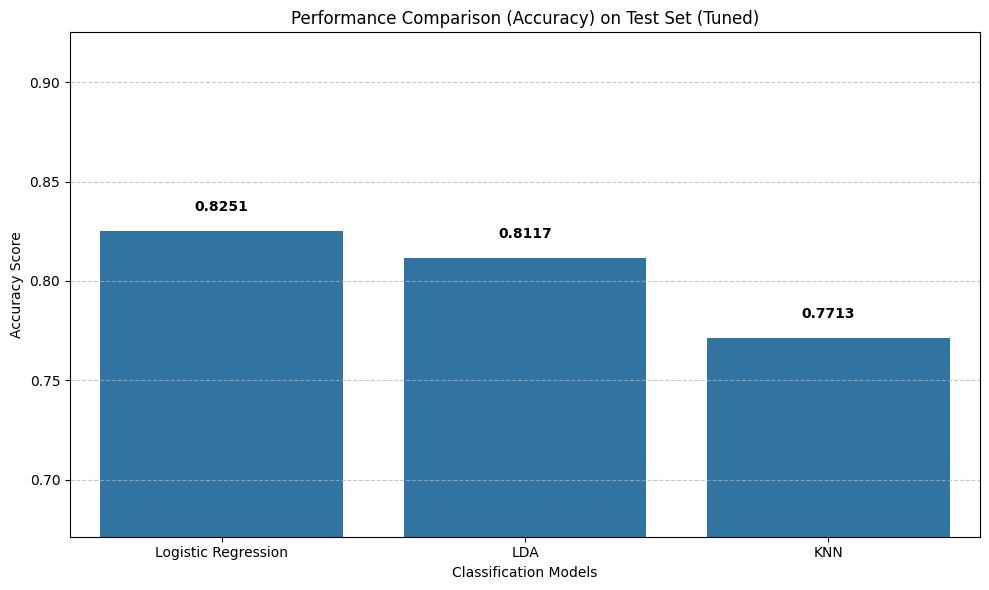

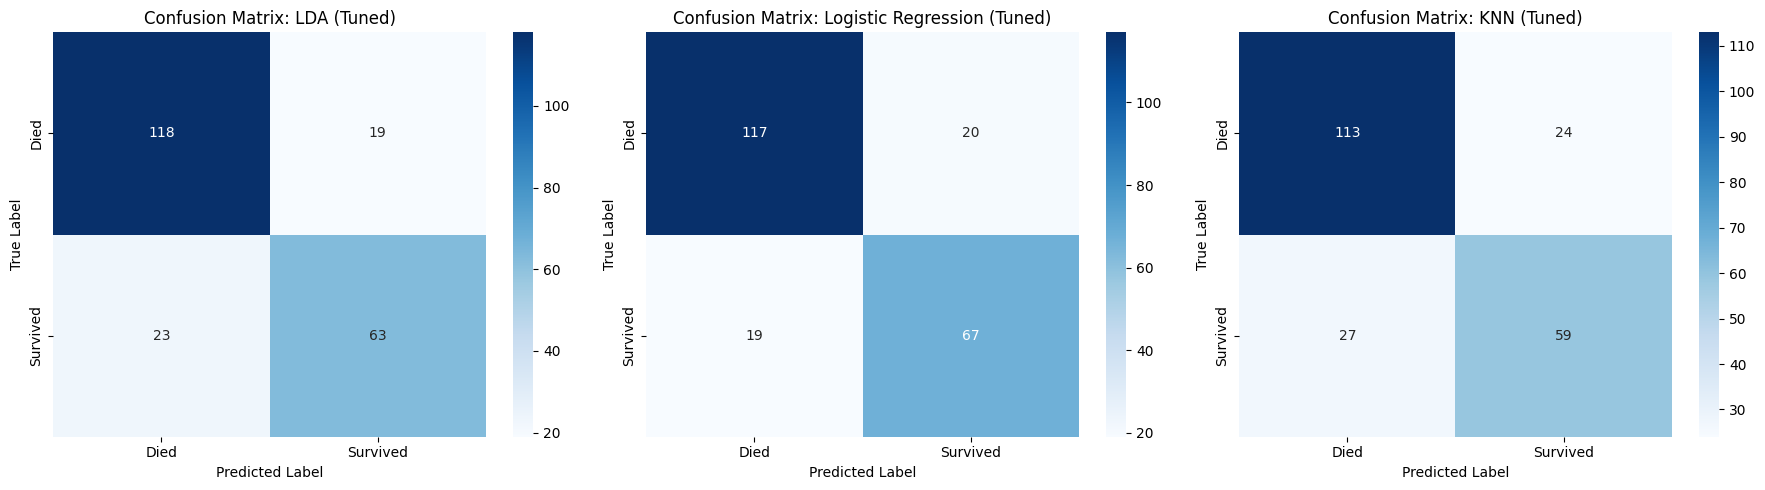

In [35]:
plot_accuracy_bar(tuned_results, title_suffix="Tuned")
plot_confusion_matrices(tuned_results, title_suffix="Tuned")

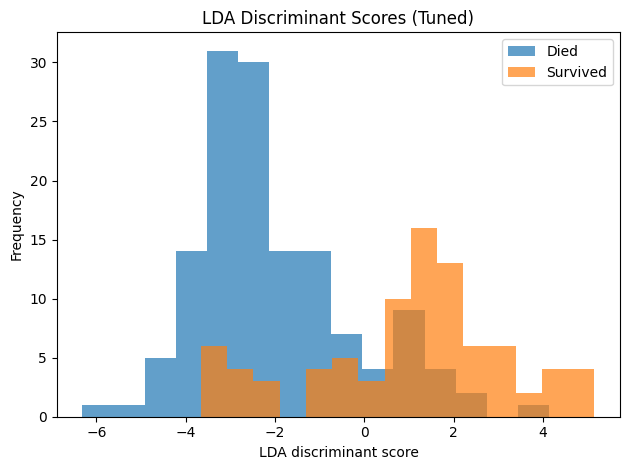

In [36]:
lda_tuned_model = best_models["LDA"]
lda_scores_tuned = lda_tuned_model.decision_function(X_test)
plt.figure()
plt.hist(lda_scores_tuned[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_tuned[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Discriminant Scores (Tuned)")
plt.legend()
plt.tight_layout()
plt.show()

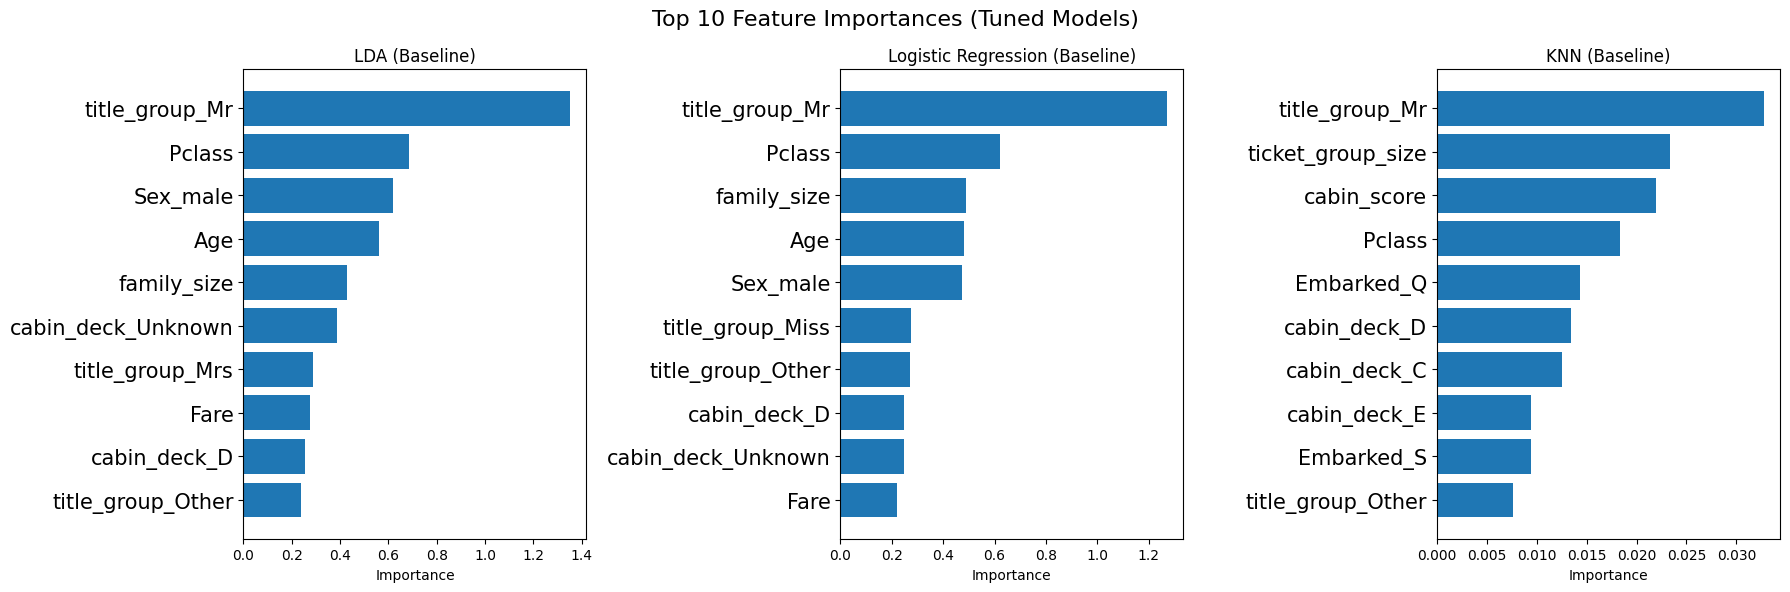

In [37]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

plot_feature_importance(
    lda_tuned_df,
    ax=axes[0],
    model_name="LDA",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    lr_tuned_df,
    ax=axes[1],
    model_name="Logistic Regression",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    knn_tuned_df,
    ax=axes[2],
    model_name="KNN",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

fig.suptitle(f"Top 10 Feature Importances (Tuned Models)", fontsize=16)
plt.tight_layout()
plt.show()

# Visuals

## EDA

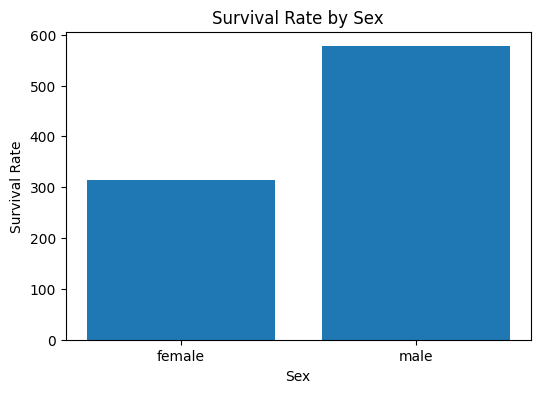

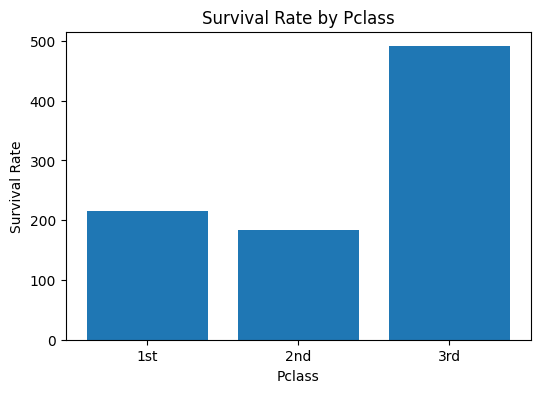

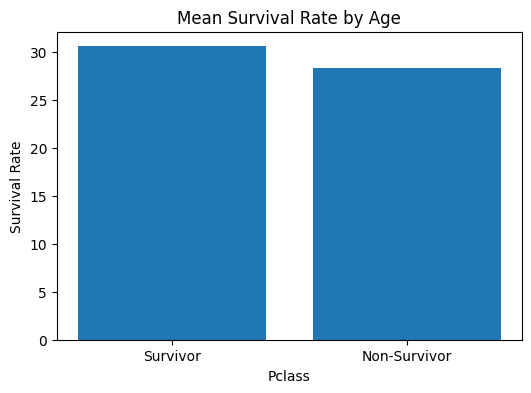

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(6, 4))
plt.bar(df_survivor_by_sex.index, df_survivor_by_sex.values)

plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Sex")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(df_survived_by_pclass.index, df_survived_by_pclass.values)
plt.xlabel("Pclass")
plt.xticks([1, 2, 3], ["1st", "2nd", "3rd"])
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Pclass")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(df_age_by_survived.index, df_age_by_survived.values)
plt.xlabel("Pclass")
plt.xticks([0, 1], ["Survivor", "Non-Survivor"])
plt.ylabel("Survival Rate")
plt.title("Mean Survival Rate by Age")
plt.show()
for i, pclass in enumerate(sorted(X_train["Pclass"].unique())):
    axes[i].hist(X_train[X_train["Pclass"] == pclass]["Age"], bins=30, alpha=0.7)
    axes[i].set_title(f"Pclass {pclass}")
    axes[i].set_xlabel("Age")
    if i == 0:
        axes[i].set_ylabel("Frequency")

fig.suptitle("Age Distribution by Passenger Class", y=1.05)
plt.tight_layout()
plt.show()

## Baseline Models

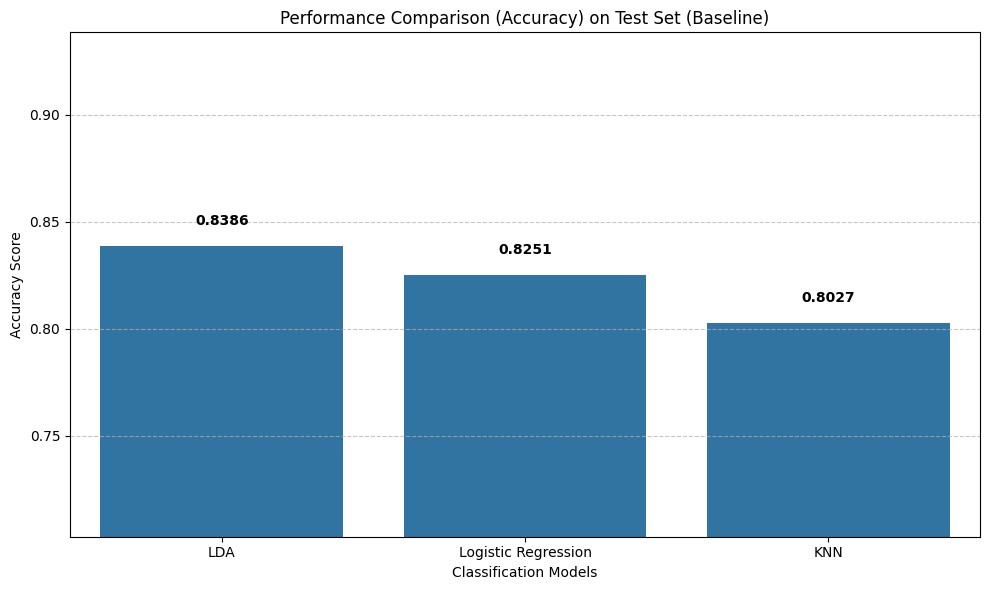

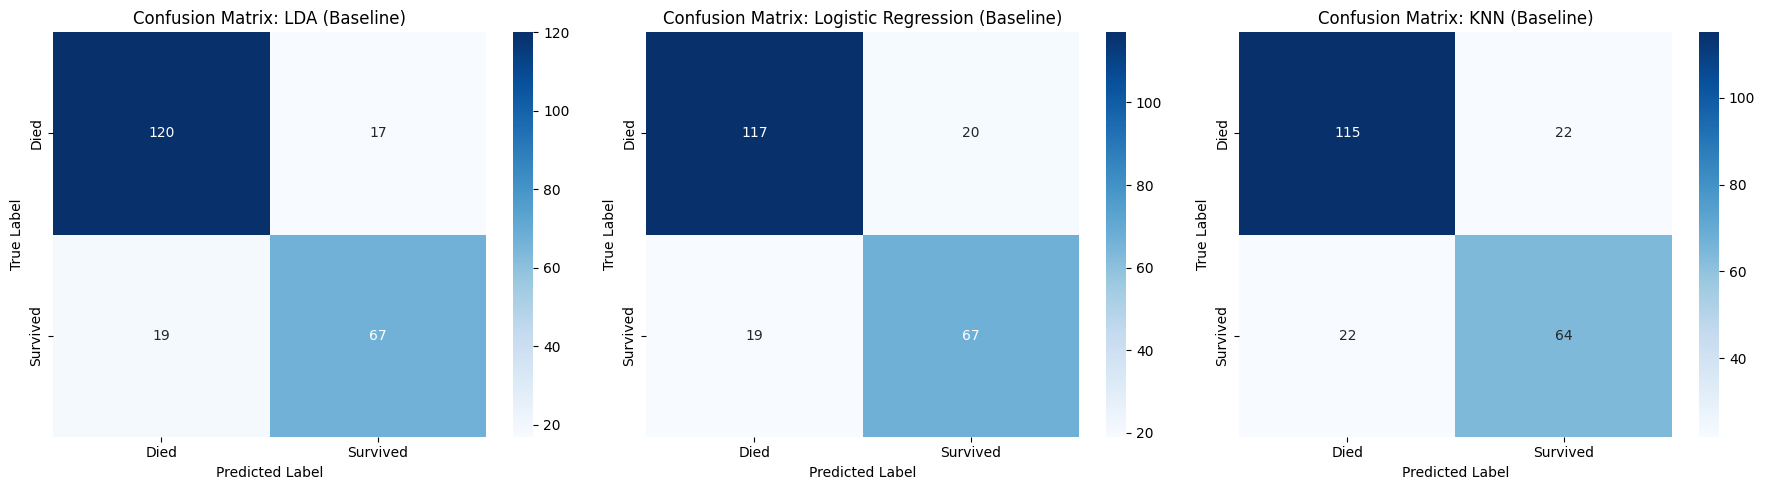

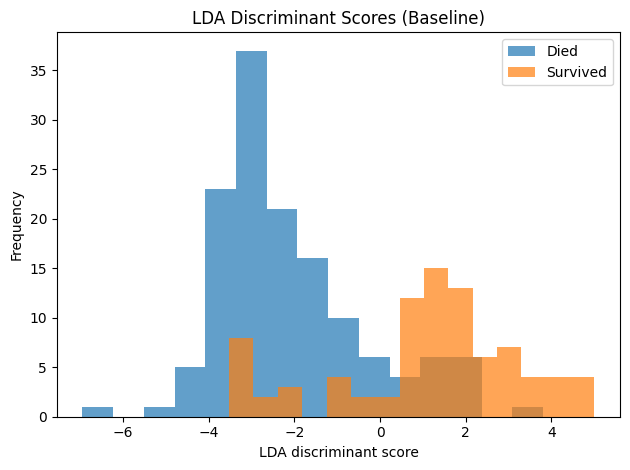

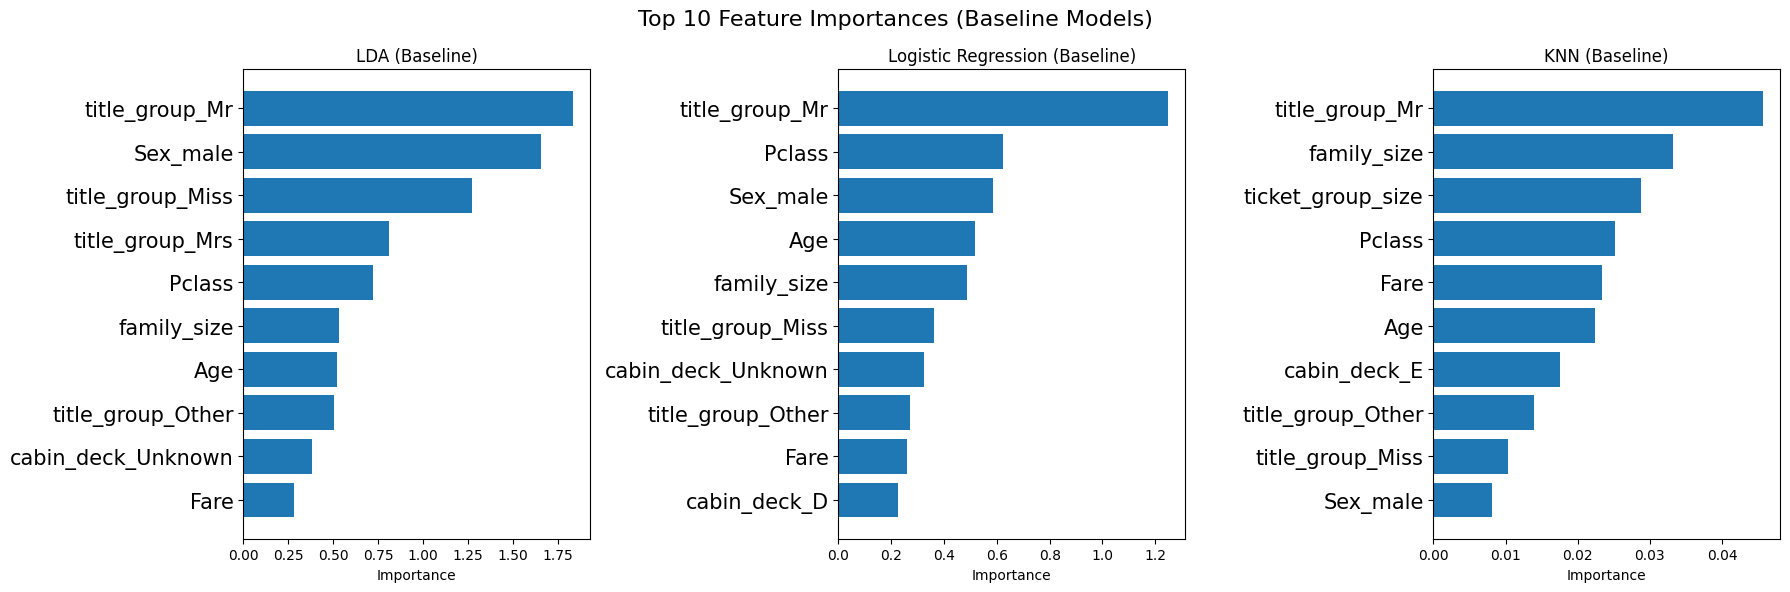

In [39]:
plot_accuracy_bar(baseline_results, title_suffix="Baseline")
plot_confusion_matrices(baseline_results, title_suffix="Baseline")

lda_baseline_model = baseline_models["LDA"]
lda_scores_baseline = lda_baseline_model.decision_function(X_test)
plt.figure()
plt.hist(lda_scores_baseline[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_baseline[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Discriminant Scores (Baseline)")
plt.legend()
plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

plot_feature_importance(
    lda_baseline_df,
    ax=axes[0],
    model_name="LDA",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    lr_baseline_df,
    ax=axes[1],
    model_name="Logistic Regression",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

plot_feature_importance(
    knn_baseline_df,
    ax=axes[2],
    model_name="KNN",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=10,
    title_suffix="Baseline"
)

fig.suptitle("Top 10 Feature Importances (Baseline Models)", fontsize=16)
plt.tight_layout()
plt.show()

## Tuned Models

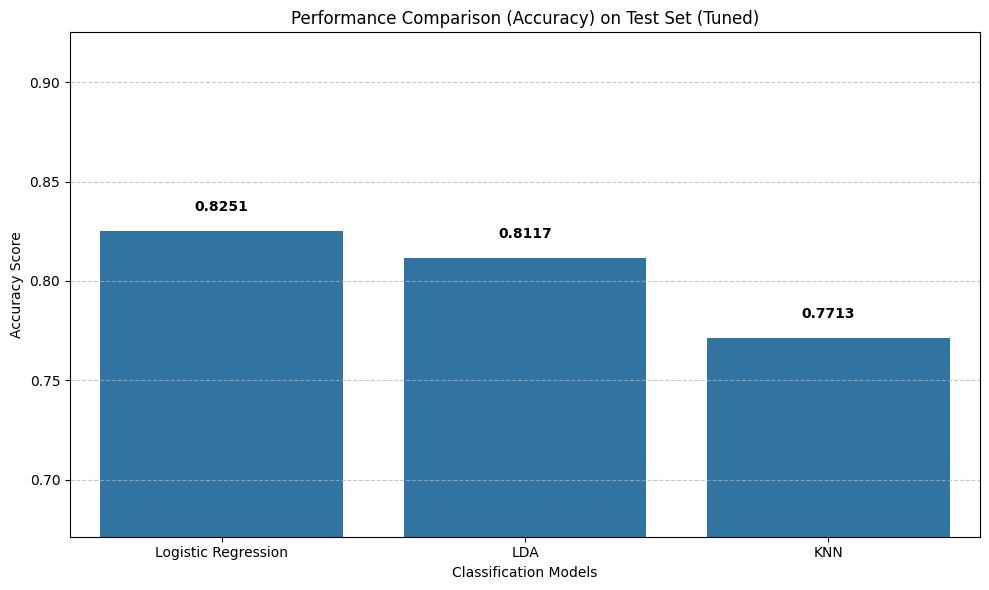

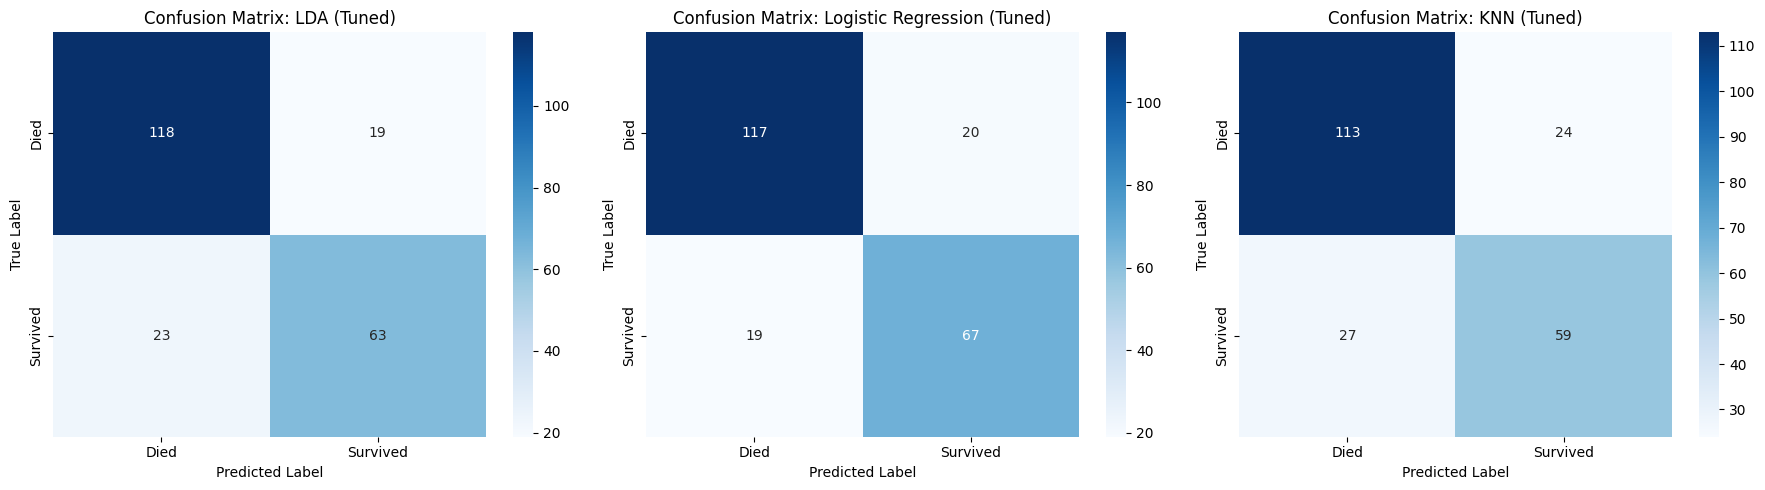

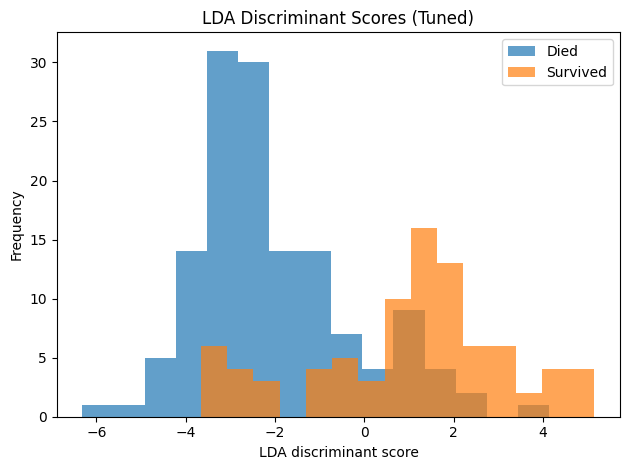

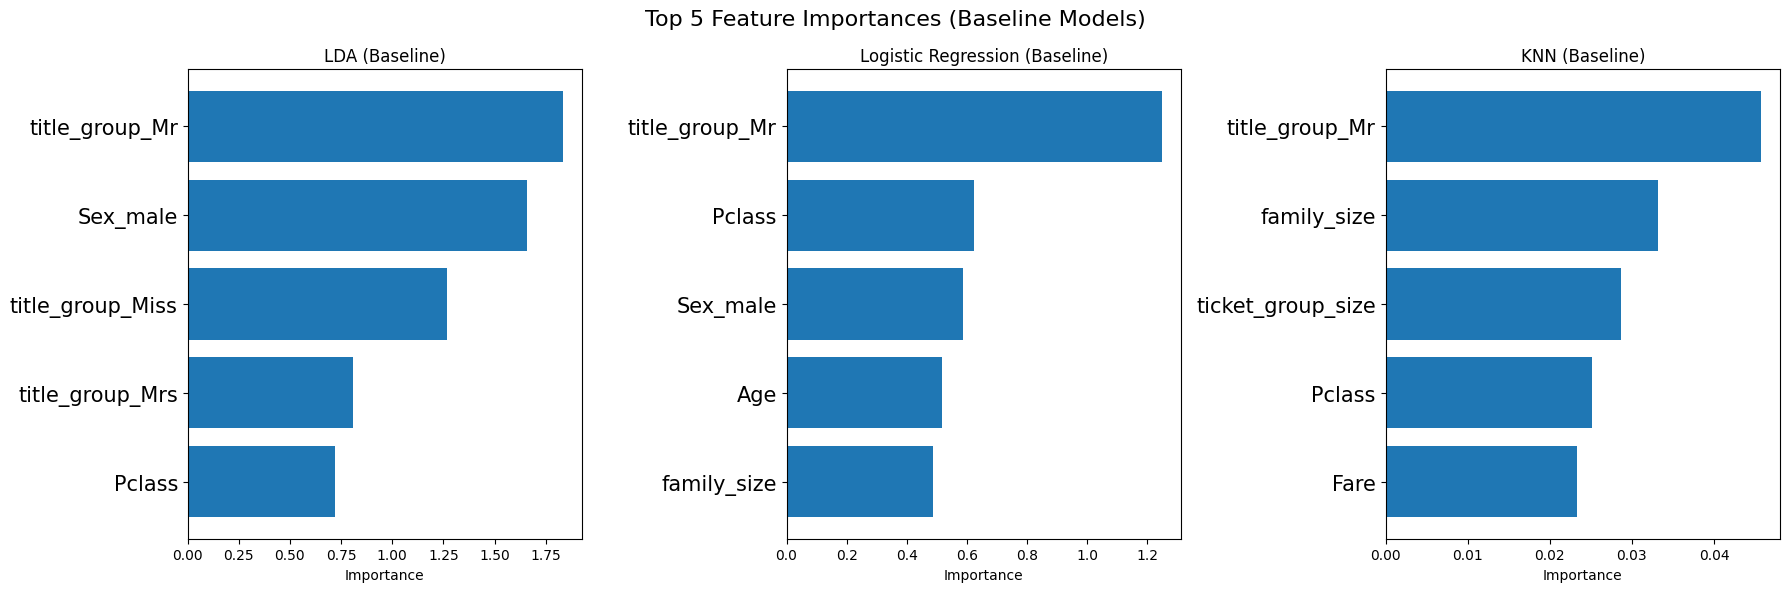

In [40]:
plot_accuracy_bar(tuned_results, title_suffix="Tuned")
plot_confusion_matrices(tuned_results, title_suffix="Tuned")

lda_tuned_model = best_models["LDA"]
lda_scores_tuned = lda_tuned_model.decision_function(X_test)
plt.figure()
plt.hist(lda_scores_tuned[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores_tuned[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Discriminant Scores (Tuned)")
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)

plot_feature_importance(
    lda_baseline_df,
    ax=axes[0],
    model_name="LDA",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=5,
    title_suffix="Baseline"
)

plot_feature_importance(
    lr_baseline_df,
    ax=axes[1],
    model_name="Logistic Regression",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=5,
    title_suffix="Baseline"
)

plot_feature_importance(
    knn_baseline_df,
    ax=axes[2],
    model_name="KNN",
    feature_col="feature",
    importance_col="abs_coef",
    top_n=5,
    title_suffix="Baseline"
)

fig.suptitle("Top 5 Feature Importances (Baseline Models)", fontsize=16)
plt.tight_layout()
plt.show()